# Loading Packages

In [1]:
!pip install -q lightgbm gpboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.3 MB/s eta 0:00:00


In [2]:
!pip install -q panelsplit > /dev/null

In [17]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gpboost as gpb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from panelsplit import PanelSplit
import os
import pickle
import random
import time
from datetime import timedelta

# Set style
plt.style.use('ggplot')
%matplotlib inline

# View max columns
pd.set_option('display.max_columns', None)

# Helper Functions

In [18]:
# Cross-validation class
class CrossValidation:
    def __init__(self, data, pred_vars, group_vars, periods, param_grid, n_splits=3, gap=0, test_size=1, plot=True):
        self.data = data
        self.pred_vars = pred_vars
        self.group_vars = group_vars
        self.periods = periods
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.gap = gap
        self.test_size = test_size
        self.plot = plot

        self.best_params = {'GPBoost': None, 'LightGBM': None}
        self.all_metrics = {'GPBoost': [], 'LightGBM': []}
        self.gpboost_predictions = []
        self.lightgbm_predictions = []
        self.gpboost_importances_split = []
        self.lightgbm_importances_split = []
        self.gpboost_importances_gain = []
        self.lightgbm_importances_gain = []
        self.gpboost_avg_importances_split = None
        self.lightgbm_avg_importances_split = None
        self.gpboost_avg_importances_gain = None
        self.lightgbm_avg_importances_gain = None

        self.gpboost_feature_mapping = {
            'YEAR_C': 'Year (Centered)',
            'POPULATION_CWC1': 'Population (CWC-1)',
            'FACILITIES_CWC1': 'Facilities (CWC-1)',
            'POPULATION_CWC2': 'Population (CWC-2)',
            'FACILITIES_CWC2': 'Facilities (CWC-2)',
            'POPULATION_L3_CGM': 'Population (CGM-3)',
            'FACILITIES_L3_CGM': 'Facilities (CGM-3)',
            'OWNER_TYPE_D1_CWC1': 'Owner: Private (CWC-1)',
            'OWNER_TYPE_D2_CWC1': 'Owner: PPP (CWC-1)',
            'OWNER_TYPE_D1_CWC2': 'Owner: Private (CWC-2)',
            'OWNER_TYPE_D2_CWC2': 'Owner: PPP (CWC-2)',
            'OWNER_TYPE_D1_L3_CGM': 'Owner: Private (CGM-3)',
            'OWNER_TYPE_D2_L3_CGM': 'Owner: PPP (CGM-3)',
            'PWS_TYPE_D1_CWC1': 'Servicer: NTNCWS (CWC-1)',
            'PWS_TYPE_D2_CWC1': 'Servicer: TNCWS (CWC-1)',
            'PWS_TYPE_D1_CWC2': 'Servicer: NTNCWS (CWC-2)',
            'PWS_TYPE_D2_CWC2': 'Servicer: TNCWS (CWC-2)',
            'PWS_TYPE_D1_L3_CGM': 'Servicer: NTNCWS (CGM-3)',
            'PWS_TYPE_D2_L3_CGM': 'Servicer: TNCWS (CGM-3)',
            'SOURCE_D1_CWC1': 'Source: Surface (CWC-1)',
            'SOURCE_D2_CWC1': 'Source: Unknown (CWC-1)',
            'SOURCE_D1_CWC2': 'Source: Surface (CWC-2)',
            'SOURCE_D2_CWC2': 'Source: Unknown (CWC-2)',
            'SOURCE_D1_L3_CGM': 'Source: Surface (CGM-3)',
            'SOURCE_D2_L3_CGM': 'Source: Unknown (CGM-3)',
            'WHOLESALER_D1_CWC1': 'Wholesaler: Yes (CWC-1)',
            'WHOLESALER_D1_CWC2': 'Wholesaler: Yes (CWC-2)',
            'WHOLESALER_D1_L3_CGM': 'Wholesaler: Yes (CGM-3)',
            'POV_RATE_CGM': 'Poverty Rate (CGM-3)',
            'PERCENT_REP_CGM': 'Pct Republican (CGM-3)',
            'AVG_PRECIP_CGM': 'Precipitation (CGM-3)',
            'AVG_TEMP_CGM': 'Temperature (CGM-3)'
        }

        self.lightgbm_feature_mapping = {
            **self.gpboost_feature_mapping,
            'PWS_ID': 'Water System ID',
            'COUNTY': 'County Served'
        }

    def _standardize(self, X_train, X_test):
        scaler = MinMaxScaler()
        numeric_cols = [col for col in self.pred_vars if col != 'YEAR_C' and self.data[col].dtype in ['float64', 'int64']]
        X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])
        return X_train, X_test

    def _calculate_metrics(self, y_true, y_pred, y_train):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        naive_mae = np.mean(np.abs(np.diff(y_train)))
        mase = mae / naive_mae

        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MASE': mase
        }
        return metrics

    def _determine_likelihood(self, y_train):
        mean_y = np.mean(y_train)
        variance_y = np.var(y_train)
        dispersion = variance_y / mean_y if mean_y > 0 else float('inf')

        if dispersion > 2.0:
            return 'negative_binomial'
        else:
            return 'poisson'

    def _run_hyperparameter_tuning(self, X, y, groups):
        best_params = {'GPBoost': None, 'LightGBM': None}
        best_scores = {'GPBoost': float('inf'), 'LightGBM': float('inf')}

        cv = PanelSplit(periods=self.periods, n_splits=self.n_splits, gap=self.gap, test_size=self.test_size, plot=self.plot)
        param_grid = list(ParameterGrid(self.param_grid))

        fold_scores = {'GPBoost': {}, 'LightGBM': {}}

        for params in param_grid:
            fold_scores['GPBoost'][str(params)] = []
            fold_scores['LightGBM'][str(params)] = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X), start=1):
            print(f"Hyperparameter tuning fold {fold}")

            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            groups_train, groups_val = groups.iloc[train_idx], groups.iloc[val_idx]

            X_train_gpboost, X_val_gpboost = X_train[self.pred_vars], X_val[self.pred_vars]
            X_train_lightgbm, X_val_lightgbm = X_train[self.pred_vars + self.group_vars], X_val[self.pred_vars + self.group_vars]

            X_train_gpboost, X_val_gpboost = self._standardize(X_train_gpboost, X_val_gpboost)
            X_train_lightgbm, X_val_lightgbm = self._standardize(X_train_lightgbm, X_val_lightgbm)

            # Create nested categories
            nested_categories_train = gpb.get_nested_categories(groups_train['COUNTY'], groups_train['PWS_ID'])
            nested_categories_val = gpb.get_nested_categories(groups_val['COUNTY'], groups_val['PWS_ID'])

            likelihood = self._determine_likelihood(y_train)

            for params in param_grid:
                try:
                    # GPBoost
                    cov_optimizer = 'adam'
                    train_set = gpb.Dataset(X_train_gpboost, y_train)
                    gp_model = gpb.GPModel(group_data=nested_categories_train, likelihood=likelihood)
                    gp_model.set_optim_params(params={'optimizer_cov': cov_optimizer})
                    print(f"Using covariance optimizer: '{cov_optimizer}'")
                    model = gpb.train(params=params, train_set=train_set, gp_model=gp_model)
                    y_pred = model.predict(data=X_val_gpboost, group_data_pred=nested_categories_val, predict_var=True)['response_mean']
                    score = mean_squared_error(y_val, y_pred)
                    print(f"GPBoost fold {fold} with params {params} - MSE: {score}")
                    fold_scores['GPBoost'][str(params)].append(score)
                except Exception as e:
                    print(f"GPBoost tuning failed for parameters {params} with exception: {e}")

                try:
                    # LightGBM
                    categorical_features = [col for col in self.group_vars if col in X_train_lightgbm.columns]
                    lgb_train = lgb.Dataset(X_train_lightgbm, label=y_train, categorical_feature=categorical_features)
                    model = lgb.train(params, lgb_train)
                    y_pred = model.predict(X_val_lightgbm)
                    score = mean_squared_error(y_val, y_pred)
                    print(f"LightGBM fold {fold} with params {params} - MSE: {score}")
                    fold_scores['LightGBM'][str(params)].append(score)
                except Exception as e:
                    print(f"LightGBM tuning failed for parameters {params} with exception: {e}")

        # Calculate average MSE score for each hyperparameter set across all folds
        for model in ['GPBoost', 'LightGBM']:
            for params_str, scores in fold_scores[model].items():
                avg_score = np.mean(scores)
                if avg_score < best_scores[model]:
                    best_scores[model] = avg_score
                    best_params[model] = eval(params_str)

        print("Best hyperparameters found:")
        print(f"GPBoost: {best_params['GPBoost']}")
        print(f"LightGBM: {best_params['LightGBM']}")

        self.best_params = best_params

    def _run_generalization_evaluation(self, X, y, groups):
        fold_metrics = {'GPBoost': [], 'LightGBM': []}
        fold_predictions = {'GPBoost': [], 'LightGBM': []}
        importances_split = {'GPBoost': [], 'LightGBM': []}
        importances_gain = {'GPBoost': [], 'LightGBM': []}

        cv = PanelSplit(periods=self.periods, n_splits=self.n_splits, gap=self.gap, test_size=self.test_size, plot=self.plot)

        for fold, (train_idx, test_idx) in enumerate(cv.split(X), start=1):
            print(f"Generalization performance evaluation fold {fold}")

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

            X_train_gpboost, X_test_gpboost = X_train[self.pred_vars], X_test[self.pred_vars]
            X_train_lightgbm, X_test_lightgbm = X_train[self.pred_vars + self.group_vars], X_test[self.pred_vars + self.group_vars]

            X_train_gpboost, X_test_gpboost = self._standardize(X_train_gpboost, X_test_gpboost)
            X_train_lightgbm, X_test_lightgbm = self._standardize(X_train_lightgbm, X_test_lightgbm)

            # Create nested categories
            nested_categories_train = gpb.get_nested_categories(groups_train['COUNTY'], groups_train['PWS_ID'])
            nested_categories_test = gpb.get_nested_categories(groups_test['COUNTY'], groups_test['PWS_ID'])

            likelihood = self._determine_likelihood(y_train)

            try:
                # GPBoost
                cov_optimizer = 'adam'
                train_set = gpb.Dataset(X_train_gpboost, y_train)
                gp_model = gpb.GPModel(group_data=nested_categories_train, likelihood=likelihood)
                gp_model.set_optim_params(params={'optimizer_cov': cov_optimizer})
                print(f"Using covariance optimizer: '{cov_optimizer}'")
                model = gpb.train(params=self.best_params['GPBoost'], train_set=train_set, gp_model=gp_model)
                y_pred = model.predict(data=X_test_gpboost, group_data_pred=nested_categories_test, predict_var=True)['response_mean']
                metrics = self._calculate_metrics(y_test, y_pred, y_train)
                print(f"GPBoost fold {fold} metrics: {metrics}")
                fold_metrics['GPBoost'].append(metrics)
                fold_predictions['GPBoost'].append((test_idx, y_test, y_pred))
                importances_split['GPBoost'].append(dict(zip(X_test_gpboost.columns, model.feature_importance(importance_type='split'))))
                importances_gain['GPBoost'].append(dict(zip(X_test_gpboost.columns, model.feature_importance(importance_type='gain'))))
            except Exception as e:
                print(f"GPBoost training failed with best parameters with exception: {e}")

            try:
                # LightGBM
                categorical_features = [col for col in self.group_vars if col in X_train_lightgbm.columns]
                lgb_train = lgb.Dataset(X_train_lightgbm, label=y_train, categorical_feature=categorical_features)
                model = lgb.train(self.best_params['LightGBM'], lgb_train)
                y_pred = model.predict(X_test_lightgbm)
                metrics = self._calculate_metrics(y_test, y_pred, y_train)
                print(f"LightGBM fold {fold} metrics: {metrics}")
                fold_metrics['LightGBM'].append(metrics)
                fold_predictions['LightGBM'].append((test_idx, y_test, y_pred))
                importances_split['LightGBM'].append(dict(zip(X_test_lightgbm.columns, model.feature_importance(importance_type='split'))))
                importances_gain['LightGBM'].append(dict(zip(X_test_lightgbm.columns, model.feature_importance(importance_type='gain'))))
            except Exception as e:
                print(f"LightGBM training failed with best parameters with exception: {e}")

        avg_metrics = {model: pd.DataFrame(fold_metrics[model]).mean().to_dict() for model in ['GPBoost', 'LightGBM']}
        avg_importances_split = {model: pd.DataFrame(importances_split[model]).mean().to_dict() for model in ['GPBoost', 'LightGBM']}
        avg_importances_gain = {model: pd.DataFrame(importances_gain[model]).mean().to_dict() for model in ['GPBoost', 'LightGBM']}

        return fold_metrics, fold_predictions, avg_metrics, avg_importances_split, avg_importances_gain

    def run(self):
        print("Running cross-validated hyperparameter tuning...")
        X = self.data[self.pred_vars + self.group_vars]
        y = self.data['VIOLATIONS']
        groups = self.data[self.group_vars]

        # Step 1: Cross-validated hyperparameter tuning
        self._run_hyperparameter_tuning(X, y, groups)

        print("Running generalization performance evaluation...")

        # Step 2: Generalization performance evaluation
        fold_metrics, fold_predictions, avg_metrics, avg_importances_split, avg_importances_gain = self._run_generalization_evaluation(X, y, groups)

        for model in ['GPBoost', 'LightGBM']:
            self.all_metrics[model] = fold_metrics[model]
            self.gpboost_predictions = fold_predictions['GPBoost']
            self.lightgbm_predictions = fold_predictions['LightGBM']
            self.gpboost_importances_split = avg_importances_split['GPBoost']
            self.lightgbm_importances_split = avg_importances_split['LightGBM']
            self.gpboost_importances_gain = avg_importances_gain['GPBoost']
            self.lightgbm_importances_gain = avg_importances_gain['LightGBM']

        self.gpboost_avg_metrics = avg_metrics['GPBoost']
        self.lightgbm_avg_metrics = avg_metrics['LightGBM']
        self.gpboost_avg_importances_split = avg_importances_split['GPBoost']
        self.lightgbm_avg_importances_split = avg_importances_split['LightGBM']
        self.gpboost_avg_importances_gain = avg_importances_gain['GPBoost']
        self.lightgbm_avg_importances_gain = avg_importances_gain['LightGBM']

        print("Average GPBoost metrics across all cross-validation folds:")
        print(self.gpboost_avg_metrics)

        print("Average LightGBM metrics across all cross-validation folds:")
        print(self.lightgbm_avg_metrics)

        return (self.all_metrics, self.gpboost_predictions, self.lightgbm_predictions,
                self.gpboost_importances_split, self.lightgbm_importances_split,
                self.gpboost_importances_gain, self.lightgbm_importances_gain,
                self.gpboost_avg_importances_split, self.lightgbm_avg_importances_split,
                self.gpboost_avg_importances_gain, self.lightgbm_avg_importances_gain,
                self.gpboost_avg_metrics, self.lightgbm_avg_metrics)

    def create_avg_metrics_df(self):
        gpboost_df = pd.DataFrame(self.gpboost_avg_metrics, index=['GPBoost'])
        lightgbm_df = pd.DataFrame(self.lightgbm_avg_metrics, index=['LightGBM'])
        return pd.concat([gpboost_df, lightgbm_df])

    def plot_avg_metrics(self):
        avg_metrics_df = self.create_avg_metrics_df()
        metrics_to_plot = avg_metrics_df.copy()

        # Remove MSE from the metrics to plot
        metrics_to_plot = metrics_to_plot.drop('MSE', axis=1)

        fig, ax = plt.subplots(figsize=(10, 6))
        metrics_to_plot = metrics_to_plot.T

        # Plot the bars
        metrics_to_plot.plot(kind='bar', ax=ax, color=['green', 'dodgerblue'])

        ax.set_title('Averaged Metrics Across Folds')
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.legend(['GPBoost', 'LightGBM'], loc='upper right')
        ax.set_xticklabels(metrics_to_plot.index, rotation=0)

        # Annotate the bars with the metric values
        for p in ax.patches:
            if p.get_height() > 0:
                value = p.get_height()
                ax.annotate(f'{value:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                            ha='center', va='bottom')

        plt.show()

    def plot_feature_importances(self):
        self._plot_feature_importances(self.gpboost_avg_importances_split, 'GPBoost Feature Importances (Split)', 'green', self.gpboost_feature_mapping)
        self._plot_feature_importances(self.gpboost_avg_importances_gain, 'GPBoost Feature Importances (Gain)', 'green', self.gpboost_feature_mapping)
        self._plot_feature_importances(self.lightgbm_avg_importances_split, 'LightGBM Feature Importances (Split)', 'dodgerblue', self.lightgbm_feature_mapping)
        self._plot_feature_importances(self.lightgbm_avg_importances_gain, 'LightGBM Feature Importances (Gain)', 'dodgerblue', self.lightgbm_feature_mapping)

    def _plot_feature_importances(self, importances, title, color, feature_mapping):
        if not importances:
            print("Importance data is empty.")
            return

        # Map the feature names using the feature mapping
        importances = {feature_mapping.get(name, name): value for name, value in importances.items()}

        # Sort by importance
        sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        sorted_feature_names, sorted_values = zip(*sorted_importances)

        plt.figure(figsize=(10, 8))
        bars = plt.barh(sorted_feature_names, sorted_values, color=color)
        plt.xlabel('Importance')
        plt.title(title)
        plt.gca().invert_yaxis()

        # Adding text labels to bars
        for bar, value in zip(bars, sorted_values):
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', ha='left')

        plt.show()

# Reading in the Data

In [19]:
# Read in the data
data = pd.read_csv('centered_data_unscaled.csv')

# Sort the data
data = data.sort_values(['PWS_ID', 'YEAR_C'])

# View the data
data.head()

,PWS_ID,OWNER_TYPE,YEAR_FULL,COUNTY,PWS_TYPE,POPULATION,SERV_CON,SOURCE,WHOLESALER,FACILITIES,VIOLATIONS,SITE_VISITS,MED_INCOME,POV_RATE,AVG_PRECIP,AVG_TEMP,PERCENT_REP,PERCENT_DEM,PERCENT_OTH,YEAR_FAC,YEAR,YEAR_C,POPULATION_L2,FACILITIES_L2,POPULATION_L3,FACILITIES_L3,POPULATION_CWC1,FACILITIES_CWC1,POPULATION_CWC2,FACILITIES_CWC2,POPULATION_L2_CGM,FACILITIES_L2_CGM,POPULATION_L3_CGM,FACILITIES_L3_CGM,POV_RATE_CGM,AVG_PRECIP_CGM,AVG_TEMP_CGM,PERCENT_REP_CGM,OWNER_TYPE_D1,OWNER_TYPE_D2,PWS_TYPE_D1,PWS_TYPE_D2,SOURCE_D1,SOURCE_D2,WHOLESALER_D1,OWNER_TYPE_D1_L2,OWNER_TYPE_D2_L2,PWS_TYPE_D1_L2,PWS_TYPE_D2_L2,SOURCE_D1_L2,SOURCE_D2_L2,WHOLESALER_D1_L2,OWNER_TYPE_D1_L3,OWNER_TYPE_D2_L3,PWS_TYPE_D1_L3,PWS_TYPE_D2_L3,SOURCE_D1_L3,SOURCE_D2_L3,WHOLESALER_D1_L3,OWNER_TYPE_D1_CWC1,OWNER_TYPE_D2_CWC1,PWS_TYPE_D1_CWC1,PWS_TYPE_D2_CWC1,SOURCE_D1_CWC1,SOURCE_D2_CWC1,WHOLESALER_D1_CWC1,OWNER_TYPE_D1_CWC2,OWNER_TYPE_D2_CWC2,PWS_TYPE_D1_CWC2,PWS_TYPE_D2_CWC2,SOURCE_D1_CWC2,SOURCE_D2_CWC2,WHOLESALER_D1_CWC2,OWNER_TYPE_D1_L2_CGM,OWNER_TYPE_D2_L2_CGM,PWS_TYPE_D1_L2_CGM,PWS_TYPE_D2_L2_CGM,SOURCE_D1_L2_CGM,SOURCE_D2_L2_CGM,WHOLESALER_D1_L2_CGM,OWNER_TYPE_D1_L3_CGM,OWNER_TYPE_D2_L3_CGM,PWS_TYPE_D1_L3_CGM,PWS_TYPE_D2_L3_CGM,SOURCE_D1_L3_CGM,SOURCE_D2_L3_CGM,WHOLESALER_D1_L3_CGM
0,CA0103040,Private,2013,Alameda,CWS,100.0,19,GW,No,16,2,4,72112,0.125,5.08,59.5,0.1405,0.5643,0.2952,2013,1,0,70.0,8.8,102437.828571,13.090476,30.0,7.2,-102367.828571,-4.290476,-6293.809825,-0.146563,96074.018747,4.143913,-0.032842,-16.049184,-0.591134,-0.179827,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204762,0.080952,0.095238,0.238095,0.571429,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795238,-0.080952,-0.095238,-0.238095,-0.571429,0.0,-0.133333,0.348615,-0.01276,-0.191448,-0.387509,-0.150487,-0.015786,-0.013449,-0.446623,0.068192,-0.09621,-0.149414,0.420942,-0.015786,0.119884
1,CA0103040,Private,2014,Alameda,CWS,100.0,19,GW,No,8,2,5,73775,0.129,19.88,62.0,0.1372,0.5606,0.3022,2014,2,1,70.0,8.8,102437.828571,13.090476,30.0,-0.8,-102367.828571,-4.290476,-6293.809825,-0.146563,96074.018747,4.143913,-0.028842,-1.249184,1.908866,-0.183127,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204762,0.080952,0.095238,0.238095,0.571429,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795238,-0.080952,-0.095238,-0.238095,-0.571429,0.0,-0.133333,0.348615,-0.01276,-0.191448,-0.387509,-0.150487,-0.015786,-0.013449,-0.446623,0.068192,-0.09621,-0.149414,0.420942,-0.015786,0.119884
2,CA0103040,Private,2015,Alameda,CWS,100.0,19,GW,No,8,2,5,75619,0.125,10.39,61.1,0.1336,0.5523,0.3141,2015,3,2,70.0,8.8,102437.828571,13.090476,30.0,-0.8,-102367.828571,-4.290476,-6293.809825,-0.146563,96074.018747,4.143913,-0.032842,-10.739184,1.008866,-0.186727,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204762,0.080952,0.095238,0.238095,0.571429,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795238,-0.080952,-0.095238,-0.238095,-0.571429,0.0,-0.133333,0.348615,-0.01276,-0.191448,-0.387509,-0.150487,-0.015786,-0.013449,-0.446623,0.068192,-0.09621,-0.149414,0.420942,-0.015786,0.119884
3,CA0103040,Private,2016,Alameda,CWS,100.0,19,GW,No,8,2,5,79831,0.120,22.55,60.4,0.1297,0.5626,0.3077,2016,4,3,70.0,8.8,102437.828571,13.090476,30.0,-0.8,-102367.828571,-4.290476,-6293.809825,-0.146563,96074.018747,4.143913,-0.037842,1.420816,0.308866,-0.190627,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204762,0.080952,0.095238,0.238095,0.571429,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795238,-0.080952,-0.095238,-0.238095,-0.571429,0.0,-0.133333,0.348615,-0.01276,-0.191448,-0.387509,-0.150487,-0.015786,-0.013449,-0.446623,0.068192,-0.09621,-0.149414,0.420942,-0.015786,0.119884
4,CA0103040,Private,2017,Alameda,CWS,50.0,19,GW,No,8,54,5,85743,0.113,24.97,60.5,0.1207,0.5760,0.3033,2017,5,4,70.0,8.8,102437.828571,13.090476,-20.0,-0.8,-102367.828571,-4.290476,-6293.809825,-0.146563,96074.018747,4.143913,-0.044842,3.840816,0.408866,-0.199627,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204762,0.080952,0.095238,0.238095,0.571429,0.0,0.133333,0.0,0.0,0

In [20]:
# # Sample random systems for quick test
# random_systems = data['PWS_ID'].unique()
# sampled_systems = np.random.choice(random_systems, 100, replace=False)
# data = data[data['PWS_ID'].isin(sampled_systems)]

In [21]:
# View datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66770 entries, 0 to 66769
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PWS_ID                66770 non-null  object 
 1   OWNER_TYPE            66770 non-null  object 
 2   YEAR_FULL             66770 non-null  int64  
 3   COUNTY                66770 non-null  object 
 4   PWS_TYPE              66770 non-null  object 
 5   POPULATION            66770 non-null  float64
 6   SERV_CON              66770 non-null  int64  
 7   SOURCE                66770 non-null  object 
 8   WHOLESALER            66770 non-null  object 
 9   FACILITIES            66770 non-null  int64  
 10  VIOLATIONS            66770 non-null  int64  
 11  SITE_VISITS           66770 non-null  int64  
 12  MED_INCOME            66770 non-null  int64  
 13  POV_RATE              66770 non-null  float64
 14  AVG_PRECIP            66770 non-null  float64
 15  AVG_TEMP           

In [22]:
# Check for missing values
data.isnull().sum().sum()

0

# Preparing the Data

In [23]:
# Define the predictor variables for GPBoost
pred_vars = [
    'YEAR_C',
    'POPULATION_CWC1', 'FACILITIES_CWC1',
    'POPULATION_CWC2', 'FACILITIES_CWC2',
    'POPULATION_L3_CGM', 'FACILITIES_L3_CGM',
    'OWNER_TYPE_D1_CWC1', 'OWNER_TYPE_D2_CWC1',
    'OWNER_TYPE_D1_CWC2', 'OWNER_TYPE_D2_CWC2',
    'OWNER_TYPE_D1_L3_CGM', 'OWNER_TYPE_D2_L3_CGM',
    'PWS_TYPE_D1_CWC1', 'PWS_TYPE_D2_CWC1',
    'PWS_TYPE_D1_CWC2', 'PWS_TYPE_D2_CWC2',
    'PWS_TYPE_D1_L3_CGM', 'PWS_TYPE_D2_L3_CGM',
    'SOURCE_D1_CWC1', 'SOURCE_D2_CWC1',
    'SOURCE_D1_CWC2', 'SOURCE_D2_CWC2',
    'SOURCE_D1_L3_CGM', 'SOURCE_D2_L3_CGM',
    'WHOLESALER_D1_CWC1',
    'WHOLESALER_D1_CWC2',
    'WHOLESALER_D1_L3_CGM',
    'POV_RATE_CGM', 'PERCENT_REP_CGM', 'AVG_PRECIP_CGM', 'AVG_TEMP_CGM'
]

# Define the grouping variables
group_vars = ['PWS_ID', 'COUNTY']

In [24]:
# Convert object types to categorical
data['PWS_ID'] = data['PWS_ID'].astype('category')
data['COUNTY'] = data['COUNTY'].astype('category')

In [25]:
# Filter the data
data = data[pred_vars + group_vars + ['VIOLATIONS']]
data.head()

,YEAR_C,POPULATION_CWC1,FACILITIES_CWC1,POPULATION_CWC2,FACILITIES_CWC2,POPULATION_L3_CGM,FACILITIES_L3_CGM,OWNER_TYPE_D1_CWC1,OWNER_TYPE_D2_CWC1,OWNER_TYPE_D1_CWC2,OWNER_TYPE_D2_CWC2,OWNER_TYPE_D1_L3_CGM,OWNER_TYPE_D2_L3_CGM,PWS_TYPE_D1_CWC1,PWS_TYPE_D2_CWC1,PWS_TYPE_D1_CWC2,PWS_TYPE_D2_CWC2,PWS_TYPE_D1_L3_CGM,PWS_TYPE_D2_L3_CGM,SOURCE_D1_CWC1,SOURCE_D2_CWC1,SOURCE_D1_CWC2,SOURCE_D2_CWC2,SOURCE_D1_L3_CGM,SOURCE_D2_L3_CGM,WHOLESALER_D1_CWC1,WHOLESALER_D1_CWC2,WHOLESALER_D1_L3_CGM,POV_RATE_CGM,PERCENT_REP_CGM,AVG_PRECIP_CGM,AVG_TEMP_CGM,PWS_ID,COUNTY,VIOLATIONS
0,0,30.0,7.2,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.032842,-0.179827,-16.049184,-0.591134,CA0103040,Alameda,2
1,1,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.028842,-0.183127,-1.249184,1.908866,CA0103040,Alameda,2
2,2,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.032842,-0.186727,-10.739184,1.008866,CA0103040,Alameda,2
3,3,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.037842,-0.190627,1.420816,0.308866,CA0103040,Alameda,2
4,4,-20.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.044842,-0.199627,3.840816,0.408866,CA0103040,Alameda,54


In [26]:
# View datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66770 entries, 0 to 66769
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   YEAR_C                66770 non-null  int64   
 1   POPULATION_CWC1       66770 non-null  float64 
 2   FACILITIES_CWC1       66770 non-null  float64 
 3   POPULATION_CWC2       66770 non-null  float64 
 4   FACILITIES_CWC2       66770 non-null  float64 
 5   POPULATION_L3_CGM     66770 non-null  float64 
 6   FACILITIES_L3_CGM     66770 non-null  float64 
 7   OWNER_TYPE_D1_CWC1    66770 non-null  float64 
 8   OWNER_TYPE_D2_CWC1    66770 non-null  float64 
 9   OWNER_TYPE_D1_CWC2    66770 non-null  float64 
 10  OWNER_TYPE_D2_CWC2    66770 non-null  float64 
 11  OWNER_TYPE_D1_L3_CGM  66770 non-null  float64 
 12  OWNER_TYPE_D2_L3_CGM  66770 non-null  float64 
 13  PWS_TYPE_D1_CWC1      66770 non-null  float64 
 14  PWS_TYPE_D2_CWC1      66770 non-null  float64 
 15  PW

# Outlier Detection

In [27]:
# Outlier-handling class
class OutlierHandler:
    def __init__(self, data, gap_threshold=100):
        self.data = data
        self.gap_threshold = gap_threshold
        self.outlier_systems = []
        self.outlier_observations = []
        self.gap_lengths = []
        self.cleaned_data = None

    def _identify_system_outliers(self, system_data):
        violations = system_data['VIOLATIONS']
        system_outliers = violations[(violations - violations.shift(1).fillna(violations.iloc[0])).abs() > self.gap_threshold]
        return system_outliers

    def _identify_inter_system_outliers(self, current_violations, all_violations):
        inter_system_outliers = current_violations[current_violations.apply(
            lambda x: (x - all_violations[all_violations < x].max() if len(all_violations[all_violations < x]) > 0 else x) > self.gap_threshold)]
        return inter_system_outliers

    def identify_and_remove_outliers(self):
        self.data = self.data.sort_values(['PWS_ID', 'YEAR_C'])
        all_violations = self.data['VIOLATIONS']

        # Get the unique water systems
        unique_systems = self.data['PWS_ID'].unique()

        # Iterate over each unique water system
        for i in range(len(unique_systems)):
            pws_id = unique_systems[i]
            system_data = self.data[self.data['PWS_ID'] == pws_id]
            system_violations = system_data['VIOLATIONS']

            # Identify outliers within the system
            system_outliers = self._identify_system_outliers(system_data)

            # Identify inter-system outliers
            inter_system_outliers = self._identify_inter_system_outliers(system_violations, all_violations)

            if len(system_outliers) > 0 or len(inter_system_outliers) > 0:
                # Get the first outlier index and subsequent outliers
                outlier_indices = sorted(system_outliers.index.tolist() + inter_system_outliers.index.tolist())
                if outlier_indices:
                    first_outlier_index = outlier_indices[0]
                    subsequent_outliers = system_data.loc[first_outlier_index:].index.tolist()

                    # Calculate the gap length
                    first_outlier_value = self.data.loc[first_outlier_index, 'VIOLATIONS']
                    nearest_prior_value = all_violations[all_violations < first_outlier_value].max() if len(all_violations[all_violations < first_outlier_value]) > 0 else 0
                    gap_length = first_outlier_value - nearest_prior_value
                    self.gap_lengths.append((first_outlier_index, gap_length))

                    # Record the outlier system and observations
                    self.outlier_systems.append(pws_id)
                    self.outlier_observations.extend(subsequent_outliers)

        # Remove outlier systems from the data
        self.cleaned_data = self.data[~self.data['PWS_ID'].isin(self.outlier_systems)]
        return self.cleaned_data

    def report_outliers(self):
        if len(self.outlier_systems) > 0:
            print("Outlier Systems:")
            for system in self.outlier_systems:
                print(f"PWS_ID: {system}")

            print("\nOutlier Observations:")
            for obs in self.outlier_observations:
                outlier_data = self.data.loc[obs]
                gap_length = next((gap for idx, gap in self.gap_lengths if idx == obs), "N/A")
                print(f"PWS_ID: {outlier_data['PWS_ID']}, Year: {outlier_data['YEAR_C']}, Violations: {outlier_data['VIOLATIONS']}, Gap Length: {gap_length}")
        else:
            print("No outlier systems or observations found.")

        print("\nSummary:")
        print(f"Number of unique water systems removed: {len(set(self.outlier_systems))}")
        print(f"Number of observations considered as outliers: {len(self.outlier_observations)}")
        print(f"Final number of unique water systems: {self.cleaned_data['PWS_ID'].nunique()}")

    def plot_before_after(self):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

        max_violation = max(self.data['VIOLATIONS'].max(), self.cleaned_data['VIOLATIONS'].max())
        bins = range(0, max_violation + 10, 10)

        sns.histplot(self.data['VIOLATIONS'], bins=bins, kde=True, ax=axes[0])
        axes[0].set_title('Before Removing Outliers')
        axes[0].set_ylabel('Frequency')

        sns.histplot(self.cleaned_data['VIOLATIONS'], bins=bins, kde=True, ax=axes[1])
        axes[1].set_title('After Removing Outliers')
        axes[1].set_xlabel('Violations')
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

In [28]:
# Use the class
handler = OutlierHandler(data)
data = handler.identify_and_remove_outliers()
handler.report_outliers()

print("Cleaned Data:")
data.head()

Outlier Systems:
PWS_ID: CA4910014

Outlier Observations:
PWS_ID: CA4910014, Year: 5, Violations: 276, Gap Length: 124
PWS_ID: CA4910014, Year: 6, Violations: 276, Gap Length: N/A
PWS_ID: CA4910014, Year: 7, Violations: 276, Gap Length: N/A
PWS_ID: CA4910014, Year: 8, Violations: 277, Gap Length: N/A
PWS_ID: CA4910014, Year: 9, Violations: 278, Gap Length: N/A

Summary:
Number of unique water systems removed: 1
Number of observations considered as outliers: 5
Final number of unique water systems: 6676
Cleaned Data:


,YEAR_C,POPULATION_CWC1,FACILITIES_CWC1,POPULATION_CWC2,FACILITIES_CWC2,POPULATION_L3_CGM,FACILITIES_L3_CGM,OWNER_TYPE_D1_CWC1,OWNER_TYPE_D2_CWC1,OWNER_TYPE_D1_CWC2,OWNER_TYPE_D2_CWC2,OWNER_TYPE_D1_L3_CGM,OWNER_TYPE_D2_L3_CGM,PWS_TYPE_D1_CWC1,PWS_TYPE_D2_CWC1,PWS_TYPE_D1_CWC2,PWS_TYPE_D2_CWC2,PWS_TYPE_D1_L3_CGM,PWS_TYPE_D2_L3_CGM,SOURCE_D1_CWC1,SOURCE_D2_CWC1,SOURCE_D1_CWC2,SOURCE_D2_CWC2,SOURCE_D1_L3_CGM,SOURCE_D2_L3_CGM,WHOLESALER_D1_CWC1,WHOLESALER_D1_CWC2,WHOLESALER_D1_L3_CGM,POV_RATE_CGM,PERCENT_REP_CGM,AVG_PRECIP_CGM,AVG_TEMP_CGM,PWS_ID,COUNTY,VIOLATIONS
0,0,30.0,7.2,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.032842,-0.179827,-16.049184,-0.591134,CA0103040,Alameda,2
1,1,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.028842,-0.183127,-1.249184,1.908866,CA0103040,Alameda,2
2,2,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.032842,-0.186727,-10.739184,1.008866,CA0103040,Alameda,2
3,3,30.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.037842,-0.190627,1.420816,0.308866,CA0103040,Alameda,2
4,4,-20.0,-0.8,-102367.828571,-4.290476,96074.018747,4.143913,0.0,0.0,0.795238,-0.080952,-0.446623,0.068192,0.0,0.0,-0.095238,-0.238095,-0.09621,-0.149414,0.0,0.0,-0.571429,0.0,0.420942,-0.015786,0.0,-0.133333,0.119884,-0.044842,-0.199627,3.840816,0.408866,CA0103040,Alameda,54


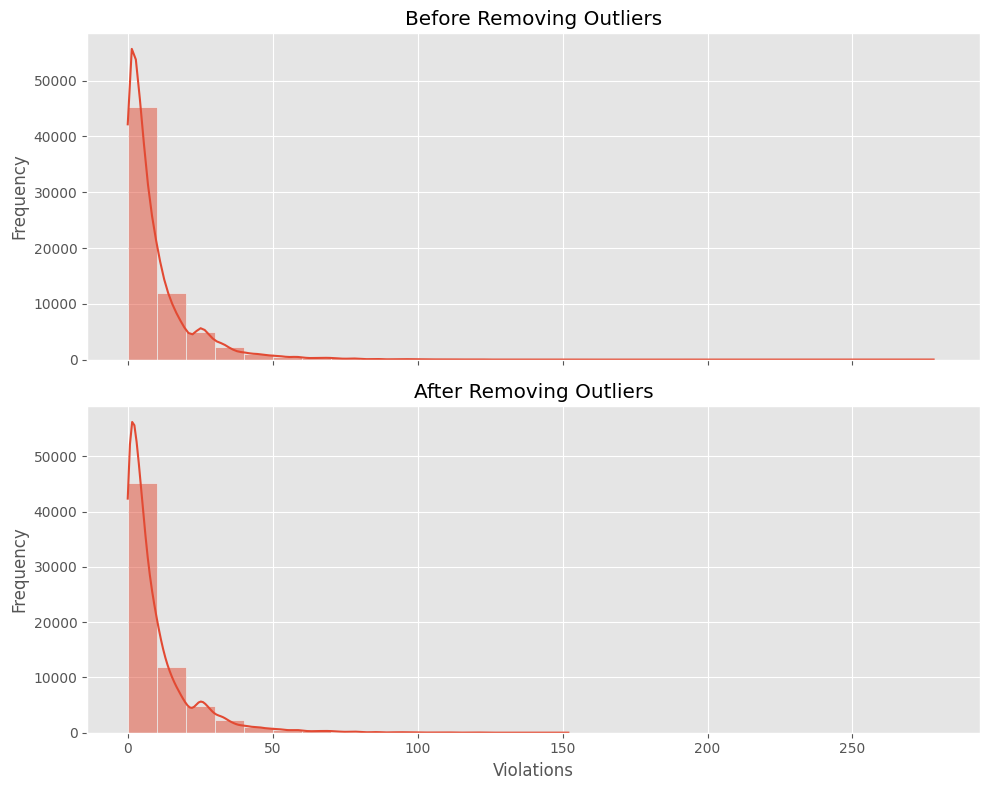

In [29]:
# Plot before and after removal of outliers
handler.plot_before_after()

# Cross-Validation

Running cross-validated hyperparameter tuning...


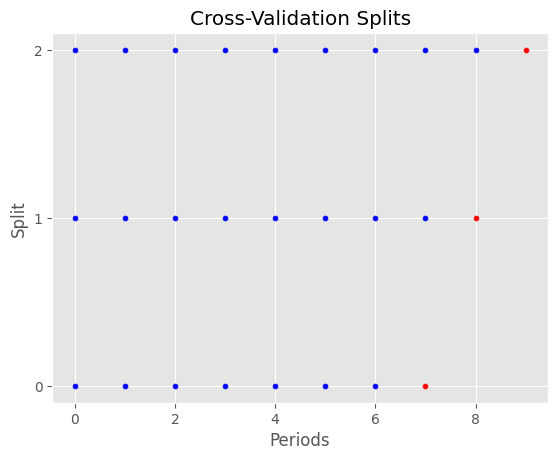

Hyperparameter tuning fold 1
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 37.41853857824555
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 117.69337667859737
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 32.41983208901391
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 100.95064744941499
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 156.60726061926002
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 4673

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 91.97835742813392
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644096
[GPBoost] [Info] Start training from score 1.644096
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 278.0331831106961
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 117.6828290994892
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 2507281.625019622
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 102.19937193308303
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 50.37731680293799
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 93.16982261151789
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 37.25646494586937
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10259


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 117.6828290994892
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 39.23049313268612
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 102.19937193308303
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 60.20334840224214
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 93.16982261151789
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644093
[GPBoost] [Info] Start training from score 1.644093
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 3583.8180018064995
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 115.09554606754645
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644096
[GPBoost] [Info] Start training from score 1.644096
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 3602.7116355195867
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 4673

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 99.40735115036564
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 889380.8142448363
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 90.34746878086789
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 3587.3654959087667
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 114.99678594651863
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 3103.0291382674313
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 4673

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 99.03211306666209
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 3943.4685234427197
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 4673

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 89.7451640241394
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 3576.574074989104
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 114.99678594651863
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 3464.5488001531767
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 4673

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 99.03211306666209
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 2916.09327910459
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 89.7451640241394
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 72.34062417983863
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732, 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 113.58553736715825
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 1452.1210363259675
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 98.18034516545097
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 12469.188370120903
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 87.98499210799588
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 72.33867561032066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732, 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 112.52029098556056
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 1494.0937433930283
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732, number of used features: 34
[LightGBM] [Info] Start training from score 9.398849
LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 96.80457744278199
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 12470.38946345699
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004461 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 87.77194855880371
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 72.340526282502
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018016 seconds.
You can set `force_row_wise=true` t

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 112.52029098556056
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644096
[GPBoost] [Info] Start training from score 1.644096
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 1493.8866183433556
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004527 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 96.80457744278199
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644094
[GPBoost] [Info] Start training from score 1.644094
GPBoost fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 238.65738157587927
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 46732

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 87.77194855880371
Hyperparameter tuning fold 2
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636658
[GPBoost] [Info] Start training from score 1.636658
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 14.098876195542799
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10277

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 127.06334222357361
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 190.54880511434826
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005126 seconds.
You can set `force_col_wise=tr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 110.83091599950617
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 363.03678453637644
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 101.32075131381667
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 20.956880782539113
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 127.17555291239844
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 25.470759443277107
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 110.94341761987789
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 21.443095628119533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 101.88290838325045
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 54.20518068628891
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 127.17555291239844
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 20.00428220472023
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 110.94341761987789
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 364.02799508030904
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 101.88290838325045
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 29.744952943745943
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 125.09214272658598
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 150.00156847527893
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 108.61581019173927
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 122.78217028961637
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 98.83843166637608
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 68.70699111449545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 124.55910166980837
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 210.45335541766406
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 109.69245452324603
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 5562.714128309901
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 100.02175383008536
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 52.87913933275896
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10277


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 124.55910166980837
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 409.9330462024887
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 109.69245452324603
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 123.55402227567112
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 5340

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 100.02175383008536
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636657
[GPBoost] [Info] Start training from score 1.636657
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 27.75103464269287
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10277
[

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 121.949243456497
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 17.841501982808744
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005105 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 106.55967200270933
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636658
[GPBoost] [Info] Start training from score 1.636658
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 694.1024365568813
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 96.92934995112405
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 27.751720399200906
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 121.89131201564832
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636658
[GPBoost] [Info] Start training from score 1.636658
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 17.842114131900306
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 105.85722718261009
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 692.6213676303079
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 95.78520053514822
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 27.751750520674147
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 121.89131201564832
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 17.841289927166088
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 105.85722718261009
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 140.47865875669353
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the train set: 53408

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 95.78520053514822
Hyperparameter tuning fold 3
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 84332.2687883973
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084, 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 50} - MSE: 136.02830187574756
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625

/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 32660.466130440338
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 100} - MSE: 118.05343649038791
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 26.25276132645875
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005780 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 15, 'num_iterations': 150} - MSE: 107.09726741443639
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 23.06102197756288
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007302 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 50} - MSE: 135.58273104988695
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633147
[GPBoost] [Info] Start training from score 1.633147
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 5465991056.606969
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 100} - MSE: 117.75731653447194
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625

/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633143
[GPBoost] [Info] Start training from score 1.633143
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 48.15159238143833
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150} - MSE: 106.82410118636427
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633147
[GPBoost] [Info] Start training from score 1.633147
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 548504713.9310949
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084, number of used features: 34
[LightGBM] [Info] Start training from score 9.643765
LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 50} - MSE: 135.58273104988695
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 908.8376117034784
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005761 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 100} - MSE: 117.75731653447194
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 157.89074259376724
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084, number of used features: 34
[LightGBM] [Info] Start training from score 9.643765
LightGBM fold 3 with params {'learning_rate': 0.08, 'max_depth': 25, 'num_iterations': 150} - MSE: 106.82410118636427
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 414.2101309458353
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005822 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 50} - MSE: 131.96275209563808
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633143
[GPBoost] [Info] Start training from score 1.633143
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 1619.9359833270512
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_col_wise=tr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 100} - MSE: 114.76666360756157
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 136.72496121898928
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=tr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 15, 'num_iterations': 150} - MSE: 103.71814747032631
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 339314.266185202
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006441 seconds.
You can set `force_col_wise=true`

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 50} - MSE: 131.96275209563808
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 1196423.3177459599
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005680 seconds.
You can set `force_col_wise=tr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 100} - MSE: 114.76666360756157
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 272423665.9180846
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 20, 'num_iterations': 150} - MSE: 103.83240548802138
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 339315.33691810386
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 50} - MSE: 131.96275209563808
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625

/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633143
[GPBoost] [Info] Start training from score 1.633143
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 515712.2589681712
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 100} - MSE: 114.76666360756157
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 1118550540251.0127
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=tr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.09, 'max_depth': 25, 'num_iterations': 150} - MSE: 103.83240548802138
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 684475424.9921606
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084, 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 50} - MSE: 130.32054843212183
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 5107281803.687517
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011159 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 100} - MSE: 112.73200330773136
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 756307690.6848242
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005612 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 150} - MSE: 101.44457476442453
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 121028238405.29343
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the train set: 60084,

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 50} - MSE: 130.55699384668574
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 18270347483.667694
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 100} - MSE: 113.27331932760589
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633145
[GPBoost] [Info] Start training from score 1.633145
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 32911.802487845714
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150} - MSE: 101.76929260210346
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 3028020058.601389
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true`

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 50} - MSE: 130.55699384668574
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 952312.4939460175
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_col_wise=true

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 100} - MSE: 113.27331932760589
Using covariance optimizer: 'adam'


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32
[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633144
[GPBoost] [Info] Start training from score 1.633144
GPBoost fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 19844869394563.254
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010776 seconds.
You can set `force_col_wise=tru

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 with params {'learning_rate': 0.1, 'max_depth': 25, 'num_iterations': 150} - MSE: 101.76929260210346
Best hyperparameters found:
GPBoost: {'learning_rate': 0.08, 'max_depth': 20, 'num_iterations': 150}
LightGBM: {'learning_rate': 0.1, 'max_depth': 20, 'num_iterations': 150}
Running generalization performance evaluation...


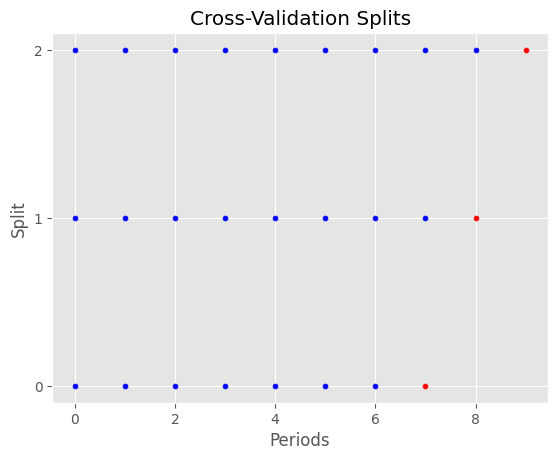

Generalization performance evaluation fold 1
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3590
[GPBoost] [Info] Number of data points in the train set: 46732, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.644095
[GPBoost] [Info] Start training from score 1.644095
GPBoost fold 1 metrics: {'MSE': 1622.119633280743, 'RMSE': 40.27554634366545, 'MAE': 3.124567985127417, 'MASE': 1.5463509294465376}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 1 metrics: {'MSE': 87.77194855880371, 'RMSE': 9.368668451749357, 'MAE': 5.7936459478447455, 'MASE': 2.8672795211938875}
Generalization performance evaluation fold 2
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3608
[GPBoost] [Info] Number of data points in the train set: 53408, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.636656
[GPBoost] [Info] Start training from score 1.636656
GPBoost fold 2 metrics: {'MSE': 363.60267799467806, 'RMSE': 19.06836851947953, 'MAE': 2.009322865230139, 'MASE': 1.1021836453616471}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10277
[LightGBM] [Info] Number of data points in the

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 2 metrics: {'MSE': 95.78520053514822, 'RMSE': 9.786991393433848, 'MAE': 5.9894745787703005, 'MASE': 3.2854356257344723}
Generalization performance evaluation fold 3
Using covariance optimizer: 'adam'
[GPBoost] [Info] Total Bins 3625
[GPBoost] [Info] Number of data points in the train set: 60084, number of used features: 32


/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:187: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] [GPBoost with negative_binomial likelihood]: initscore=1.633143
[GPBoost] [Info] Start training from score 1.633143
GPBoost fold 3 metrics: {'MSE': 27.223045792960022, 'RMSE': 5.217570870909184, 'MAE': 1.690404518073601, 'MASE': 1.0183239385525549}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10294
[LightGBM] [Info] Number of data points in the

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM fold 3 metrics: {'MSE': 101.76929260210346, 'RMSE': 10.088076754372137, 'MAE': 6.219880944961424, 'MASE': 3.7469455349180065}
Average GPBoost metrics across all cross-validation folds:
{'MSE': 670.9817856894604, 'RMSE': 21.52049524468472, 'MAE': 2.274765122810386, 'MASE': 1.2222861711202466}
Average LightGBM metrics across all cross-validation folds:
{'MSE': 95.10881389868513, 'RMSE': 9.74791219985178, 'MAE': 6.001000490525491, 'MASE': 3.299886893948789}


In [30]:
# Hyperparameter grid
param_grid = {
    'num_iterations': [50, 100, 150],
    'learning_rate': [0.08, 0.09, 0.10],
    'max_depth': [15, 20, 25]
}

# Set periods
periods = data['YEAR_C']

# Initialize the cross-validation class
cross_validation = CrossValidation(
   data=data,
   pred_vars=pred_vars,
   group_vars=group_vars,
   periods=periods,
   param_grid=param_grid,
   n_splits=3,
   gap=0,
   test_size=1,
   plot=True
)

# Run the cross-validation process
results = cross_validation.run()

# Reporting Results

In [31]:
# Create DataFrame of Averaged Metrics
avg_metrics_df = cross_validation.create_avg_metrics_df()
avg_metrics_df

,MSE,RMSE,MAE,MASE
GPBoost,670.981786,21.520495,2.274765,1.222286
LightGBM,95.108814,9.747912,6.001000,3.299887


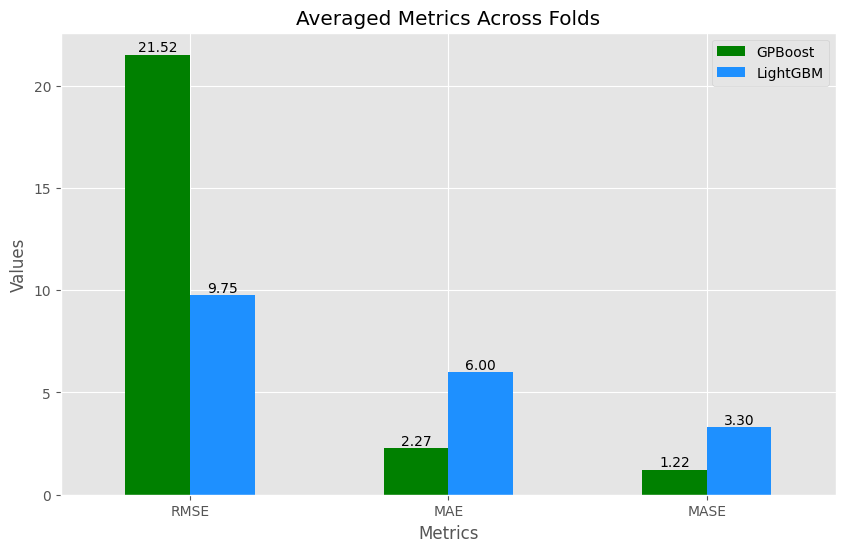

In [32]:
# Plot Averaged Metrics
cross_validation.plot_avg_metrics()

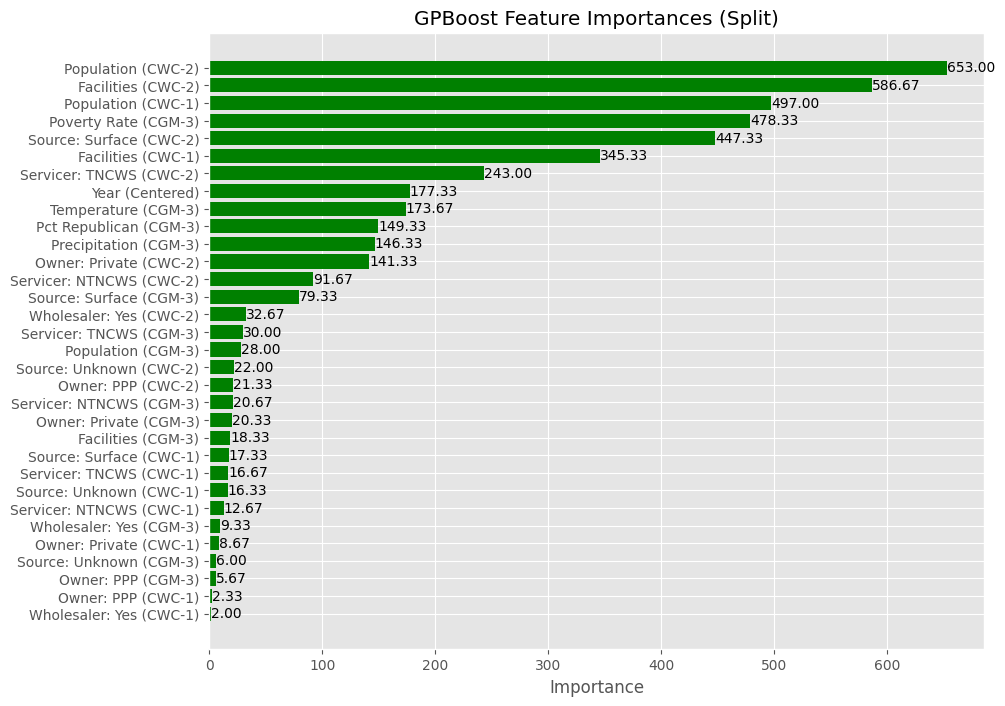

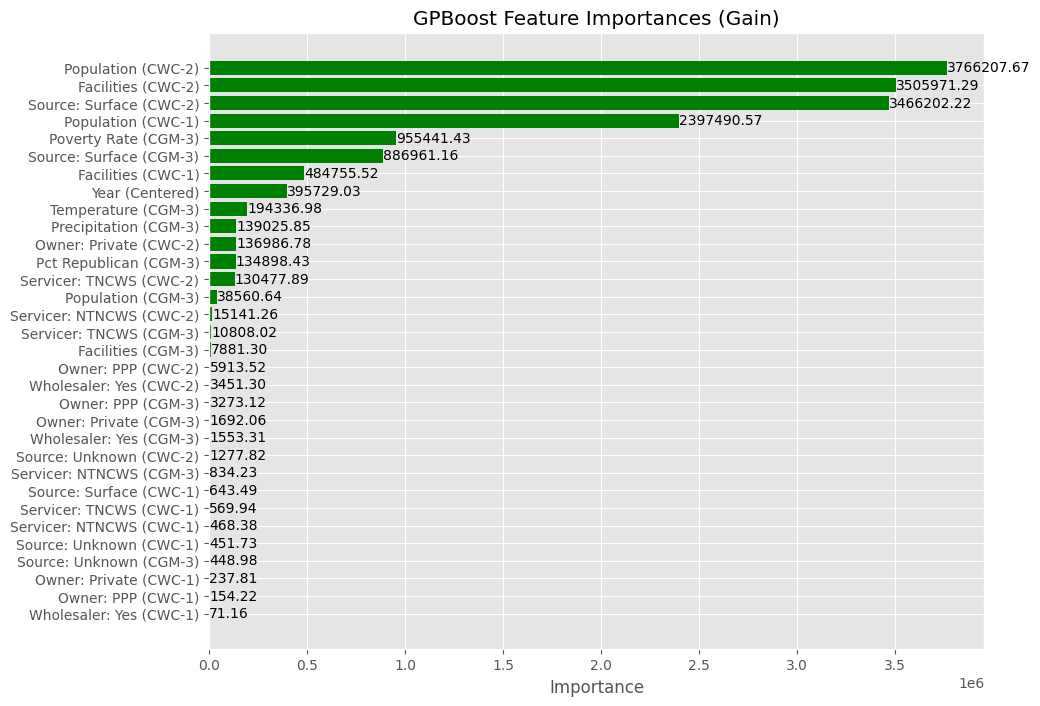

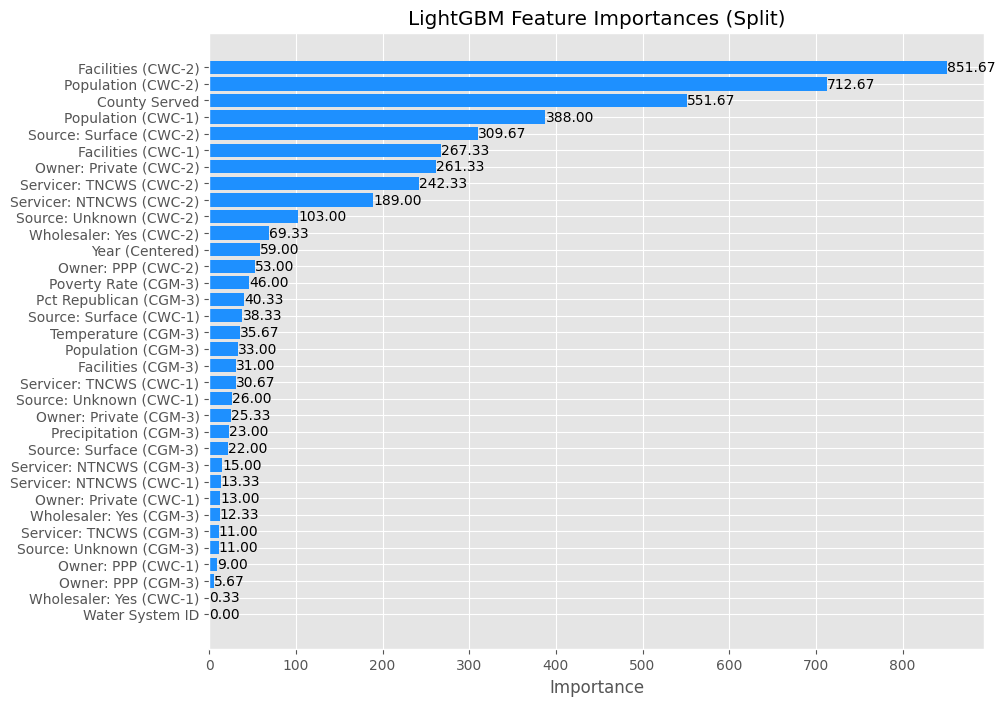

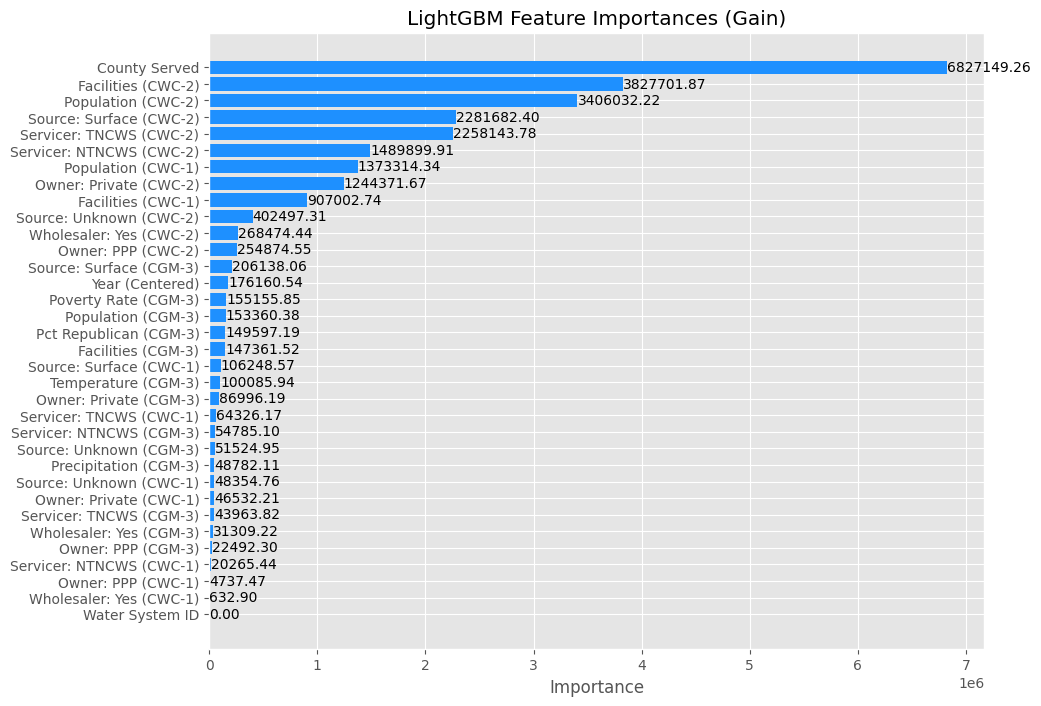

In [33]:
# Plot Feature Importances
cross_validation.plot_feature_importances()